In [1]:
import torch
from torch_geometric.data import InMemoryDataset
from tqdm import tqdm
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix, f1_score, \
    accuracy_score, precision_score, recall_score
from torch_geometric.data import Dataset
from sklearn.metrics import roc_auc_score

import clang.cindex 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

from sys import platform

In [2]:
# Configure libclang path
if platform == "linux" or platform == "linux2":
    print("Linux")
    clang.cindex.Config.set_library_file('/usr/lib/llvm-14/lib/libclang.so')
elif platform == "darwin":
    print("OS X")
    clang.cindex.Config.set_library_file('/Library/Developer/CommandLineTools/usr/lib/libclang.dylib')
elif platform == "win32":
    print("Windows")
    clang.cindex.Config.set_library_file('D:/Project/LLVM/bin/libclang.dll')

# Verify if libclang is loaded
print(clang.cindex.Config.loaded)  # Should print `True`

Linux
False


In [3]:
def save_ast(node):
    """Store the children of the AST node."""
    node.children = list(node.get_children())
    for child in node.children:
        save_ast(child)

def number_ast_nodes(node, counter=1):
    """Assign unique identifiers to each node in the AST."""
    node.identifier = counter
    counter += 1

    node.children = list(node.get_children())
    for child in node.children:
        counter = number_ast_nodes(child, counter)

    return counter

def generate_edgelist(ast_root):
    """Generate an edge list from the AST."""
    edges = [[], []]

    def walk_tree_and_add_edges(node):
        for child in node.children:
            edges[0].append(node.identifier - 1)
            edges[1].append(child.identifier - 1)
            walk_tree_and_add_edges(child)

    walk_tree_and_add_edges(ast_root)
    return torch.tensor(edges, dtype=torch.long)

def generate_features(ast_root):
    """Generate node features for the AST."""
    features = []

    def walk_tree_and_set_features(node):
        out_degree = len(node.children)
        node_id = node.identifier
        features.append([node_id, out_degree])

        for child in node.children:
            walk_tree_and_set_features(child)

    walk_tree_and_set_features(ast_root)
    return torch.tensor(features, dtype=torch.float)

def clang_process(testcase):
    """Process a test case using Clang to generate AST, edges, and features."""
    parse_list = [(testcase.filename, testcase.code)]

    index = clang.cindex.Index.create()
    translation_unit = index.parse(path=testcase.filename, unsaved_files=parse_list)
    ast_root = translation_unit.cursor

    save_ast(ast_root)
    number_ast_nodes(ast_root)

    edges_embedding = generate_edgelist(ast_root)
    nodes_embedding = generate_features(ast_root)
    
    # Check if it have a vuln or not
    
    
    if hasattr(testcase, "vuln"):
        y = torch.tensor([testcase.vuln], dtype=torch.int64)
    else:
        print("Attribute 'vuln' not found in testcase.")


    # Clean up Clang objects
    del translation_unit, ast_root, index

    return Data(x=nodes_embedding, edge_index=edges_embedding, y=y)

In [4]:
class GenDataset(Dataset):
    def __init__(self, root, csv_path, transform=None, pre_transform=None):
        """
        Args:
            root (str): Root directory where processed data will be stored.
            csv_path (str): Path to the CSV file containing the dataset.
            transform: Optional transform to be applied to the data.
            pre_transform: Optional pre-transform to be applied to the data.
        """
        self.csv_path = csv_path
        super(GenDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return []  # No raw files are needed

    @property
    def processed_file_names(self):
        """Return a list of processed file names."""
        if not hasattr(self, 'data'):
            self.data = pd.read_csv(self.csv_path)
        return [f'data_{i}.pt' for i in range(len(self.data))]

    def download(self):
        """No download needed since we are using a local CSV file."""
        pass

    def process(self):
        """Load the CSV file and process each row into a graph."""
        self.data = pd.read_csv(self.csv_path)
        for index, vuln in tqdm(self.data.iterrows(), total=len(self.data)):
            data = clang_process(vuln)
            torch.save(data, os.path.join(self.processed_dir, f'data_{index}.pt'))

    def len(self):
        """Return the number of graphs in the dataset."""
        return len(self.processed_file_names)

    def get(self, idx):
        """Load a graph from disk."""
        return torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'), weights_only=False)

In [5]:
csv_path = "Datasets/Normalized_CWE-119.csv.gz"
dataset = GenDataset(root='processed_data', csv_path=csv_path)

In [6]:
len(dataset)

48314

In [7]:
print(f"Number of features: {dataset[0].num_features}")

Number of features: 2


In [8]:
tmpData = dataset[2] # Get the first graph object
print(f"Number of edges: {tmpData.num_edges}")
print(f"Number of nodes: {tmpData.num_nodes}")

Number of edges: 23
Number of nodes: 24


In [9]:
print(dataset[2].edge_index.t())

tensor([[ 0,  1],
        [ 1,  2],
        [ 2,  3],
        [ 1,  4],
        [ 1,  5],
        [ 1,  6],
        [ 1,  7],
        [ 7,  8],
        [ 8,  9],
        [ 7, 10],
        [10, 11],
        [ 7, 12],
        [12, 13],
        [13, 14],
        [14, 15],
        [13, 16],
        [16, 17],
        [13, 18],
        [18, 19],
        [13, 20],
        [20, 21],
        [13, 22],
        [22, 23]])


In [10]:
print(dataset[2].x)

tensor([[ 1.,  1.],
        [ 2.,  5.],
        [ 3.,  1.],
        [ 4.,  0.],
        [ 5.,  0.],
        [ 6.,  0.],
        [ 7.,  0.],
        [ 8.,  3.],
        [ 9.,  1.],
        [10.,  0.],
        [11.,  1.],
        [12.,  0.],
        [13.,  1.],
        [14.,  5.],
        [15.,  1.],
        [16.,  0.],
        [17.,  1.],
        [18.,  0.],
        [19.,  1.],
        [20.,  0.],
        [21.,  1.],
        [22.,  0.],
        [23.,  1.],
        [24.,  0.]])


In [11]:
print(dataset[2].y) # 1 means vulnerable, 0 means not vulnerable 

tensor([0])


### Split dataset into training and validation sets

In [12]:
data = dataset.shuffle()
one_tenth_length = int(len(data) * 0.1)
train_dataset = data[:one_tenth_length * 8]
val_dataset = data[one_tenth_length * 8 : one_tenth_length * 9]
test_dataset = data[one_tenth_length * 9:]

In [13]:
len(train_dataset), len(val_dataset), len(test_dataset)

(38648, 4831, 4835)

In [14]:
from torch_geometric.data import DataLoader
NUM_OF_GRAPHS_PER_BATCH = 256
train_dataset_loader = DataLoader(train_dataset, batch_size=NUM_OF_GRAPHS_PER_BATCH, shuffle=True, drop_last=True)
val_dataset_loader = DataLoader(val_dataset, batch_size=NUM_OF_GRAPHS_PER_BATCH, shuffle=True, drop_last=True)
test_dataset_loader = DataLoader(test_dataset, batch_size=NUM_OF_GRAPHS_PER_BATCH, shuffle=True, drop_last=True)

# NUM_OF_GRAPHS_PER_BATCH = 64  # Reduce batch size for better training updates

# train_dataset_loader = DataLoader(train_dataset, batch_size=NUM_OF_GRAPHS_PER_BATCH, shuffle=True, drop_last=True)
# val_dataset_loader = DataLoader(val_dataset, batch_size=NUM_OF_GRAPHS_PER_BATCH, shuffle=False, drop_last=False)
# test_dataset_loader = DataLoader(test_dataset, batch_size=NUM_OF_GRAPHS_PER_BATCH, shuffle=False, drop_last=False)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## GNN model

In [15]:
import torch
from torch.nn import Linear, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool as gap, global_max_pool as gmp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Hyperparameters
embedding_size = 128
dropout_rate = 0.3
learning_rate = 0.005
patience = 5
num_epochs = 100

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(dataset.num_features, embedding_size) # to translate our node features into the size of the embedding
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        # pooling layer
        #self.pool = TopKPooling(embedding_size, ratio=0.8)
        #dropout layer
        # self.dropout = Dropout(p=dropout_rate)

        # Output layer
        self.lin1 = Linear(embedding_size*2, 128) # linear output layer ensures that we get a continuous unbounded output value. It input is the flattened vector (embedding size *2) from the pooling layer (mean and max)
        self.lin2 = Linear(128, 128)
        self.lin3 = Linear(128, 1)
        

        self.act1 = torch.nn.ReLU()
        self.act2 = torch.nn.ReLU()

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.relu(hidden)

        hidden = self.conv2(hidden, edge_index)
        hidden = F.relu(hidden)

        # hidden = self.dropout(hidden)
        
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)
        
        # Apply a final (linear) classifier.
        out = self.lin1(hidden)
        out = self.act1(out)
        out = self.lin2(out)
        out = self.act2(out)
        #out = F.dropout(out, p=0.5, training=self.training)
        out = self.lin3(out)
        out = torch.sigmoid(out)

        # return out, hidden
        return out

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize model
#model = GCN(num_features=dataset.num_features).to(device)
model = GCN().to(device)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))
# Update optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
loss_fn = torch.nn.BCELoss()

# Training function
def train():
    model.train()
    total_loss = 0

    for data in train_dataset_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x.float(), data.edge_index, data.batch)
        label = data.y.to(device)

        loss = loss_fn(output.squeeze(), label.float())
        loss.backward()

        optimizer.step()
        total_loss += loss.item()
        
    return total_loss / len(train_dataset_loader)

# Evaluation function
def evaluate(loader):
    model.eval()
    predictions, labels = [], []

    total_loss = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            pred = model(data.x.float(), data.edge_index, data.batch).squeeze()

            label_true = data.y.float()
            loss = loss_fn(pred, label_true)

            total_loss += loss.item()
            predictions.append(np.rint(pred.cpu().numpy()))
            labels.append(label_true.cpu().numpy())

    predictions = np.concatenate(predictions).ravel()
    labels = np.concatenate(labels).ravel()

    return accuracy_score(labels, predictions), total_loss / len(loader)

Number of parameters:  82945


In [16]:
# Lists to store metrics for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop with early stopping
best_val_loss = float('inf')
early_stop_counter = 0

print("Starting training...")
for epoch in range(num_epochs):
    #train_loss = train(train_dataset_loader)
    train_loss  = train()
    train_acc, _ = evaluate(train_dataset_loader)
    val_acc, val_loss = evaluate(val_dataset_loader)

    scheduler.step(val_loss)

    # Store metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break

print(f"Training finished. Best validation loss: {best_val_loss:.4f}")

Starting training...


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch   1 | Train Loss: 0.6095 | Train Acc: 0.6870 | Val Acc: 0.6927 | Val Loss: 0.5921


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch   2 | Train Loss: 0.5911 | Train Acc: 0.6957 | Val Acc: 0.6962 | Val Loss: 0.5867


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch   3 | Train Loss: 0.5852 | Train Acc: 0.7014 | Val Acc: 0.7038 | Val Loss: 0.5769


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch   4 | Train Loss: 0.5739 | Train Acc: 0.7113 | Val Acc: 0.7070 | Val Loss: 0.5673


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch   5 | Train Loss: 0.5634 | Train Acc: 0.7229 | Val Acc: 0.7148 | Val Loss: 0.5538


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch   6 | Train Loss: 0.5551 | Train Acc: 0.7214 | Val Acc: 0.7081 | Val Loss: 0.5480


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch   7 | Train Loss: 0.5452 | Train Acc: 0.7233 | Val Acc: 0.7203 | Val Loss: 0.5457


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch   8 | Train Loss: 0.5407 | Train Acc: 0.7334 | Val Acc: 0.7261 | Val Loss: 0.5307


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch   9 | Train Loss: 0.5362 | Train Acc: 0.7247 | Val Acc: 0.7233 | Val Loss: 0.5375


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  10 | Train Loss: 0.5322 | Train Acc: 0.7344 | Val Acc: 0.7281 | Val Loss: 0.5337


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  11 | Train Loss: 0.5276 | Train Acc: 0.7331 | Val Acc: 0.7209 | Val Loss: 0.5315


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 00012: reducing learning rate of group 0 to 2.5000e-03.
Epoch  12 | Train Loss: 0.5255 | Train Acc: 0.7338 | Val Acc: 0.7259 | Val Loss: 0.5377


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  13 | Train Loss: 0.5196 | Train Acc: 0.7468 | Val Acc: 0.7352 | Val Loss: 0.5203


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  14 | Train Loss: 0.5159 | Train Acc: 0.7440 | Val Acc: 0.7355 | Val Loss: 0.5214


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  15 | Train Loss: 0.5148 | Train Acc: 0.7467 | Val Acc: 0.7424 | Val Loss: 0.5218


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  16 | Train Loss: 0.5135 | Train Acc: 0.7468 | Val Acc: 0.7374 | Val Loss: 0.5189


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  17 | Train Loss: 0.5148 | Train Acc: 0.7490 | Val Acc: 0.7391 | Val Loss: 0.5204


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  18 | Train Loss: 0.5118 | Train Acc: 0.7483 | Val Acc: 0.7431 | Val Loss: 0.5237


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  19 | Train Loss: 0.5134 | Train Acc: 0.7531 | Val Acc: 0.7480 | Val Loss: 0.5143


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  20 | Train Loss: 0.5109 | Train Acc: 0.7551 | Val Acc: 0.7418 | Val Loss: 0.5107


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  21 | Train Loss: 0.5098 | Train Acc: 0.7542 | Val Acc: 0.7433 | Val Loss: 0.5142


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  22 | Train Loss: 0.5088 | Train Acc: 0.7526 | Val Acc: 0.7439 | Val Loss: 0.5144


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  23 | Train Loss: 0.5078 | Train Acc: 0.7397 | Val Acc: 0.7311 | Val Loss: 0.5355


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 00024: reducing learning rate of group 0 to 1.2500e-03.
Epoch  24 | Train Loss: 0.5090 | Train Acc: 0.7558 | Val Acc: 0.7420 | Val Loss: 0.5126


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  25 | Train Loss: 0.5043 | Train Acc: 0.7565 | Val Acc: 0.7485 | Val Loss: 0.5102


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  26 | Train Loss: 0.5016 | Train Acc: 0.7596 | Val Acc: 0.7476 | Val Loss: 0.5087


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  27 | Train Loss: 0.5013 | Train Acc: 0.7554 | Val Acc: 0.7465 | Val Loss: 0.5153


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  28 | Train Loss: 0.5009 | Train Acc: 0.7588 | Val Acc: 0.7420 | Val Loss: 0.5112


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  29 | Train Loss: 0.5006 | Train Acc: 0.7537 | Val Acc: 0.7435 | Val Loss: 0.5161


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 00030: reducing learning rate of group 0 to 6.2500e-04.
Epoch  30 | Train Loss: 0.5003 | Train Acc: 0.7589 | Val Acc: 0.7467 | Val Loss: 0.5088


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  31 | Train Loss: 0.4978 | Train Acc: 0.7623 | Val Acc: 0.7500 | Val Loss: 0.5045


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  32 | Train Loss: 0.4974 | Train Acc: 0.7632 | Val Acc: 0.7502 | Val Loss: 0.5051


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  33 | Train Loss: 0.4967 | Train Acc: 0.7618 | Val Acc: 0.7500 | Val Loss: 0.5046


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  34 | Train Loss: 0.4969 | Train Acc: 0.7627 | Val Acc: 0.7546 | Val Loss: 0.5020


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  35 | Train Loss: 0.4959 | Train Acc: 0.7643 | Val Acc: 0.7500 | Val Loss: 0.5055


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  36 | Train Loss: 0.4958 | Train Acc: 0.7622 | Val Acc: 0.7487 | Val Loss: 0.5058


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  37 | Train Loss: 0.4956 | Train Acc: 0.7620 | Val Acc: 0.7535 | Val Loss: 0.5026


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 00038: reducing learning rate of group 0 to 3.1250e-04.
Epoch  38 | Train Loss: 0.4949 | Train Acc: 0.7637 | Val Acc: 0.7507 | Val Loss: 0.5038


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch  39 | Train Loss: 0.4937 | Train Acc: 0.7622 | Val Acc: 0.7496 | Val Loss: 0.5070
Early stopping triggered!
Training finished. Best validation loss: 0.5020


In [30]:
# # Save the trained model
# model_name = 'gcn_cwe_119_test_lr_0001_p5_best'
# torch.save(model.state_dict(), model_name + '.pth')
# torch.save(model,'full_'+ model_name + '.pth')
# print("Model saved to ", model_name+'.pth')

Model saved to  gcn_cwe_119_test_lr_0001_p5_best.pth


### Ploting learning curve

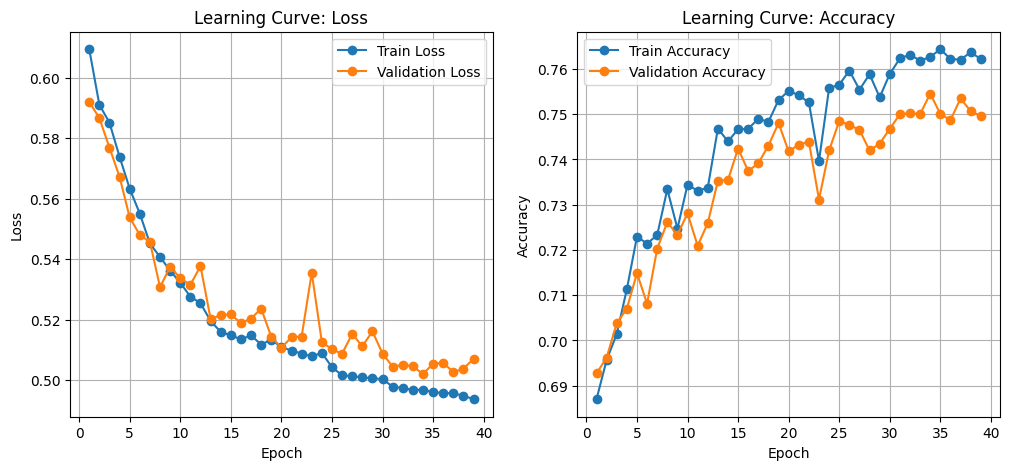

In [18]:
# Ensure tensors are moved to CPU and converted to NumPy
train_losses = [loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses = [loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]
train_accuracies = [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in train_accuracies]
val_accuracies = [acc.cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_accuracies]

# Plot Loss Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve: Loss")
plt.legend()
plt.grid()

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", marker="o")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Learning Curve: Accuracy")
plt.legend()
plt.grid()

# Show plots
plt.show()

In [19]:
# import numpy as np
# import matplotlib.pyplot as plt

# subset_ratios = np.linspace(0.1, 1.0, 10)
# train_sizes = []
# val_accuracies = []

# for ratio in subset_ratios:
#     subset_size = int(ratio * len(train_dataset))
#     subset_loader = DataLoader(torch.utils.data.Subset(train_dataset, range(subset_size)), batch_size=NUM_OF_GRAPHS_PER_BATCH, shuffle=True)
    
#     model.train()
#     for data in subset_loader:
#         data = data.to(device)
#         optimizer.zero_grad()
#         output = model(data.x.float(), data.edge_index, data.batch)
#         loss = loss_fn(output.squeeze(), data.y.float())
#         loss.backward()
#         optimizer.step()
    
#     val_acc, _ = evaluate(val_dataset_loader)
#     train_sizes.append(subset_size)
#     val_accuracies.append(val_acc)

# plt.figure(figsize=(8, 6))
# plt.plot(train_sizes, val_accuracies, marker='o', linestyle='-', color='b')
# plt.xlabel("Number of Training Samples")
# plt.ylabel("Validation Accuracy")
# plt.title("Learning Curve: Data Size vs Accuracy")
# plt.grid()
# plt.show()

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



 Confusion matrix: 
 [[1695  719]
 [ 431 1990]]

 Accuracy: 0.7622

 Precision: 0.7346

 Recall: 0.8220

 F1 Score: 0.7758


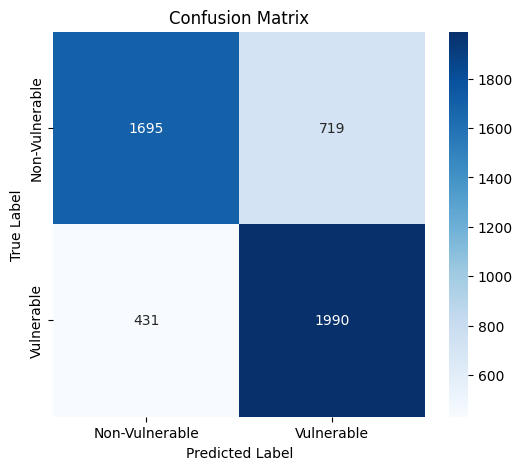

,y_real,y_pred_bin,y_pred_float
0,0,[1.0],[0.9082444906234741]
1,1,[1.0],[0.6330733299255371]
2,0,[0.0],[0.08882050216197968]
3,1,[1.0],[0.5816010236740112]
4,1,[1.0],[0.9228345155715942]
...,...,...,...
4830,1,[1.0],[0.9155144691467285]
4831,0,[0.0],[0.0754731222987175]
4832,0,[1.0],[0.7328602075576782]
4833,1,[1.0],[0.6543370485305786]


In [20]:
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

NUM_GRAPHS_PER_BATCH_1 = len(test_dataset)
test_loader_all = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH_1, drop_last=False, shuffle=True)

# Analyze the results for all graphs
test_batch = next(iter(test_loader_all))
test_batch = test_batch.to(device)  # Move to device

with torch.no_grad():
    # Forward pass
    pred = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)

    # Convert predictions to binary (0 or 1)
    pred_bin = np.rint(pred.cpu().numpy())  # Convert tensor → NumPy → Rounded binary values
    # pred_bin = np.rint(pred.detach().cpu().numpy())
    y_true = test_batch.y.cpu().numpy()  # Convert tensor → NumPy

    # Compute evaluation metrics
    accuracy = accuracy_score(y_true, pred_bin)
    precision = precision_score(y_true, pred_bin, zero_division=1)
    recall = recall_score(y_true, pred_bin, zero_division=1)
    f1 = f1_score(y_true, pred_bin)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, pred_bin)

    # Print metrics
    print(f"\n Confusion matrix: \n {cm}")
    print(f"\n Accuracy: {accuracy:.4f}")
    print(f"\n Precision: {precision:.4f}")
    print(f"\n Recall: {recall:.4f}")
    print(f"\n F1 Score: {f1:.4f}")

    # Save results in a DataFrame
    df = pd.DataFrame({
        "y_real": y_true.tolist(),
        "y_pred_bin": pred_bin.tolist(),
        "y_pred_float": pred.tolist()
    })

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Vulnerable", "Vulnerable"], yticklabels=["Non-Vulnerable", "Vulnerable"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

df  # Display DataFrame

## Predictions with source code

In [29]:
import torch
import time

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the model
# model_pred = torch.load("full_gcn_cwe_119_test_lr_0005.pth")
model_pred = torch.load("full_gcn_cwe_119_test_lr_0001_p5_best.pth")
model_pred.to(device)
model_pred.eval()  # Set the model to evaluation mode

class TestCase:
    def __init__(self, filename, code, vuln=None):
        self.filename = filename
        self.code = code
        self.vuln = vuln

# Load the source code files
with open('Sourcecode/no_vuln.c', 'r') as f:
    clear_area_code = f.read()

with open('Sourcecode/cwe_119_1.c', 'r') as f:
    hello_world_code = f.read()

# Create test case objects
clear_area_testcase = TestCase(filename='clear_area.c', code=clear_area_code, vuln=False)
vuln_testcase = TestCase(filename='cwe_119_1.c', code=hello_world_code, vuln=True)

# Preprocess the source code files
clear_area_data = clang_process(clear_area_testcase)
vuln_data = clang_process(vuln_testcase)

print("clear_area.c features:", clear_area_data.x)
print("cwe_119_1.c features:", vuln_data.x)

def predict_vulnerability(data, num_runs=5):
    """
    Perform multiple inference runs and measure execution time in milliseconds.
    """
    data = data.to(device)
    
    times = []
    with torch.no_grad():
        for _ in range(num_runs):
            start_time = time.time()  # Start time

            output = model(data.x.float(), data.edge_index, data.batch) # Train model
            # output = model_pred(data.x.float(), data.edge_index, data.batch) # Saved train model
            end_time = time.time()  # End time
            
            elapsed_time_ms = (end_time - start_time) * 1000  # Convert to milliseconds
            times.append(elapsed_time_ms)
        
        probability = output.item()  # Get probability
        prediction = torch.round(output).item()  # Round to 0 or 1
    
    avg_time_ms = sum(times) / num_runs  # Compute average inference time in ms
    return probability, prediction, avg_time_ms

# Perform inference with time measurement in milliseconds
clear_area_prob, clear_area_pred, clear_area_time_ms = predict_vulnerability(clear_area_data)
print(f"clear_area.c - Probability: {clear_area_prob:.4f}, Prediction: {'Vulnerable' if clear_area_pred == 1 else 'Safe'}, Avg Inference Time: {clear_area_time_ms:.3f} ms")

vuln_prob, vuln_pred, vuln_time_ms = predict_vulnerability(vuln_data)
print(f"cwe_119_1.c - Probability: {vuln_prob:.4f}, Prediction: {'Vulnerable' if vuln_pred == 1 else 'Safe'}, Avg Inference Time: {vuln_time_ms:.3f} ms")



clear_area.c features: tensor([[1.0000e+00, 6.8800e+02],
        [2.0000e+00, 0.0000e+00],
        [3.0000e+00, 1.0000e+00],
        ...,
        [2.5800e+03, 0.0000e+00],
        [2.5810e+03, 1.0000e+00],
        [2.5820e+03, 0.0000e+00]])
cwe_119_1.c features: tensor([[ 1.,  1.],
        [ 2.,  2.],
        [ 3.,  0.],
        [ 4.,  4.],
        [ 5.,  2.],
        [ 6.,  0.],
        [ 7.,  1.],
        [ 8.,  0.],
        [ 9.,  1.],
        [10.,  1.],
        [11.,  0.],
        [12.,  2.],
        [13.,  1.],
        [14.,  0.],
        [15.,  1.],
        [16.,  0.],
        [17.,  3.],
        [18.,  0.],
        [19.,  0.],
        [20.,  1.],
        [21.,  0.]])
clear_area.c - Probability: 0.0000, Prediction: Safe, Avg Inference Time: 7.359 ms
cwe_119_1.c - Probability: 0.7764, Prediction: Vulnerable, Avg Inference Time: 3.023 ms


In [22]:
import time

def measure_avg_time(data_samples, num_runs=10):
    """Measures average inference time over multiple runs."""
    total_time = 0.0
    for _ in range(num_runs):
        start = time.perf_counter()
        predict_vulnerability(data_samples)  # We ignore output for timing
        end = time.perf_counter()
        total_time += (end - start) * 1000  # Convert to milliseconds
    return total_time / num_runs

# Measure average time for each
avg_time_clear = measure_avg_time(clear_area_data)
avg_time_vuln = measure_avg_time(vuln_data)

# Combined average
overall_avg_time = (avg_time_clear + avg_time_vuln) / 2

print(f"clear_area.c - Avg Time: {avg_time_clear:.3f} ms (10 runs)")
print(f"cwe_119_1.c - Avg Time: {avg_time_vuln:.3f} ms (10 runs)")
print(f"\nOverall Average Inference Time: {overall_avg_time:.3f} ms")

clear_area.c - Avg Time: 16.047 ms (10 runs)
cwe_119_1.c - Avg Time: 13.539 ms (10 runs)

Overall Average Inference Time: 14.793 ms
